In [1]:
import random
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split

In [2]:
is_cuda = torch.cuda.is_available()   # GPU가 사용가능한지
device = torch.device("cuda" if is_cuda else "cpu") # GPU가 사용가능하다면 GPU를 사용 아니면 CPU 사용
print(is_cuda, device)

False cpu


In [3]:
seed = 1010
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

In [4]:
def get_mnist_dataloaders(batch_size, val=0.2, num_workers=0):
  transform = transforms.Compose([
    transforms.ToTensor(),
  ])

  # split
  mnist_train_origin = datasets.MNIST(
      root='MNIST/',
      train=True,
      download=True,
      transform=transform,
  )
  val_samples = int(len(mnist_train_origin) * val)
  train_samples = len(mnist_train_origin) - val_samples

  # dataset
  mnist_train, mnist_val = random_split(
      mnist_train_origin,
       (train_samples, val_samples),
  )
  mnist_test = datasets.MNIST(
      root='MNIST/',
      train=False,
      download=True,
      transform=transform,
  )

  # dataloader
  train_loader = DataLoader(
      dataset=mnist_train,
      batch_size=batch_size,
      drop_last=True,
      shuffle=True,
      num_workers=num_workers,
  )
  val_loader = DataLoader(
      dataset=mnist_val,
      batch_size=batch_size,
      num_workers=num_workers,
  )
  test_loader = DataLoader(
      dataset=mnist_test,
      batch_size=batch_size,
      num_workers=num_workers,
  )

  return train_loader, val_loader, test_loader

In [5]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [6]:
def train(model, dataloader, criterion, optimizer, epoch):
  # train mode
  model.train()

  # 학습 통계
  running_loss = 0
  correct = 0

  for i, (data, targets) in enumerate(dataloader):
    data.to(device), targets.to(device)   # data device로 이동

    optimizer.zero_grad()       # gradient 초기화
    outputs = model(data)       # forward
    loss = criterion(outputs, targets)    # loss 계산
    loss.backward()             # gradient 계산
    optimizer.step()            # weight update

    running_loss += loss.item()

    # Accuracy 계산
    _, predicted = torch.max(outputs, 1)
    correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 출력
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(
      f"[{epoch}/{EPOCH}]",
      f"train loss: {running_loss/len(dataloader):.4f}",
      f"train acc: {correct}/{data_num} ({acc:.2f}%)"
  )

  return running_loss/len(dataloader)

In [7]:
def validation(model, dataloader, criterion, epoch):
  # eval 모드
  model.eval()

  # 검증 통계
  correct = 0
  running_loss = 0.

  with torch.no_grad():   # gradient 계산 안하기
    for i, (data, targets) in enumerate(dataloader):
      data.to(device), targets.to(device)   # data device로 이동

      outputs = model(data)               # forward
      loss = criterion(outputs, targets)  # loss 계산

      running_loss += loss.item()

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f'[{epoch}/{EPOCH}] valid loss: {running_loss/len(dataloader):.4f} valid acc: {correct}/{data_num} ({acc:.2f}%)\n')

  return running_loss/len(dataloader)

In [8]:
def test(model, dataloader):
  # eval 모드
  model.eval()

  # 테스트 통계
  correct = 0

  with torch.no_grad():
    for data, targets in dataloader:
      data.to(device), targets.to(device)

      outputs = model(data)    # forward

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  print(f'Test Accuracy: {correct}/{data_num} ({100. * correct / data_num:.2f}%)')

In [9]:
# Hyperparameters
# Training
EPOCH = 5
BATCH_SIZE = 32
NUM_WORKERS = 1
LR = 0.001

# Model
model = LeNet()
print(model)

# MNIST dataloader
train_loader, val_loader, test_loader = \
get_mnist_dataloaders(BATCH_SIZE, val=0.2, num_workers=NUM_WORKERS)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []

for epoch in range(EPOCH):
  tloss = train(model, train_loader, criterion, optimizer, epoch)
  vloss = validation(model, val_loader, criterion, epoch)

  train_losses.append(tloss)
  val_losses.append(vloss)

test(model, test_loader)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 143kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


[0/5] train loss: 0.2642 train acc: 43969/48000 (91.60%)
[0/5] valid loss: 0.1149 valid acc: 11576/12000 (96.47%)

[1/5] train loss: 0.0866 train acc: 46677/48000 (97.24%)
[1/5] valid loss: 0.0738 valid acc: 11727/12000 (97.72%)

[2/5] train loss: 0.0599 train acc: 47105/48000 (98.14%)
[2/5] valid loss: 0.0615 valid acc: 11784/12000 (98.20%)

[3/5] train loss: 0.0485 train acc: 47280/48000 (98.50%)
[3/5] valid loss: 0.0431 valid acc: 11856/12000 (98.80%)

[4/5] train loss: 0.0391 train acc: 47404/48000 (98.76%)
[4/5] valid loss: 0.0393 valid acc: 11864/12000 (98.87%)

Test Accuracy: 9882/10000 (98.82%)


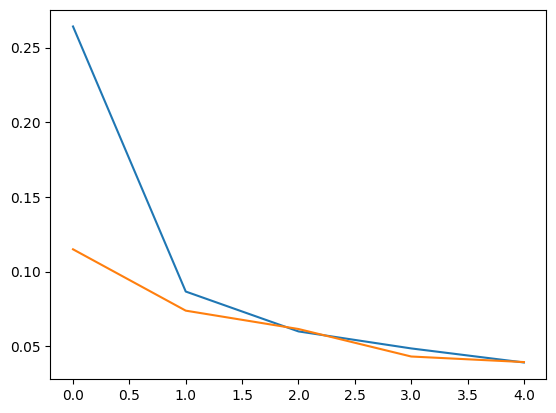

In [10]:
plt.plot(train_losses)
plt.plot(val_losses)